In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
output_data = pd.read_csv('gender_submission.csv')

In [3]:
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Checking for the unique values in the feature

categorical_features=['Age','Sex','Embarked']

for feature in categorical_features:
  print(f"Unique values for {feature}:")
  print(train[feature].value_counts())
  print()

Unique values for Age:
Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64

Unique values for Sex:
Sex
male      577
female    314
Name: count, dtype: int64

Unique values for Embarked:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64



In [7]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
# Checking for missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
train.shape

(891, 12)

<Axes: >

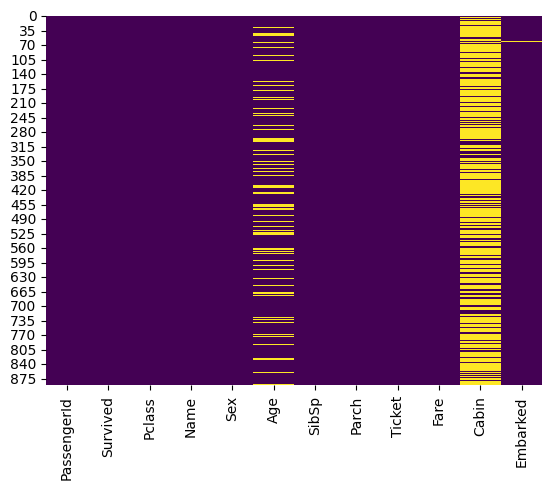

In [11]:
# Visualizing missing data
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')

In [12]:
# For 'Age', we can use the median to fill missing values
imputer = SimpleImputer(strategy='median')
train['Age'] = imputer.fit_transform(train[['Age']])
test['Age'] = imputer.transform(test[['Age']])

In [13]:
# For 'Embarked', we can use the most frequent value
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

In [14]:
# For 'Fare' in test set, use the median
test['Fare'].fillna(test['Fare'].median(), inplace=True)

In [15]:
# Select only numeric columns
numeric_columns = train.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()
correlation_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000


In [16]:
correlation = train[['Age', 'Survived']].corr()
print(correlation)

              Age  Survived
Age       1.00000  -0.06491
Survived -0.06491   1.00000


<Axes: >

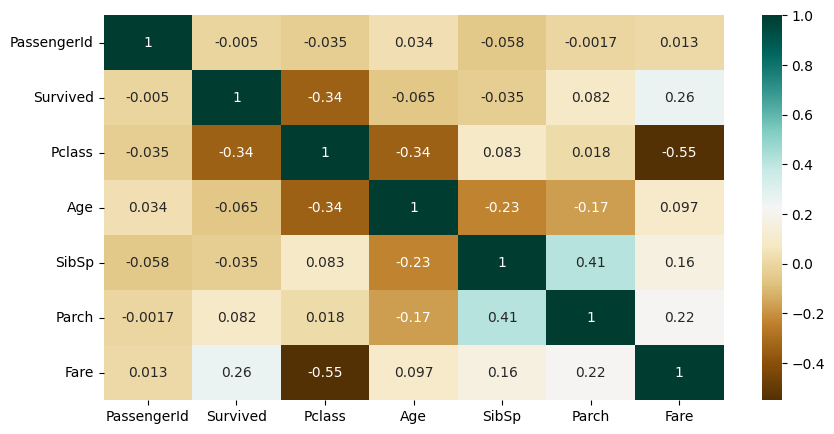

In [17]:
plt.figure(figsize=(10,5))    # Adjusting the size of figure, you can change it

correlation = numeric_columns.corr()       # Calculating the correlation

sns.heatmap(correlation,cmap="BrBG",annot=True)  # Displaying the correlation using the heap map    # Here Br: Brown. B: Blue, G: Green

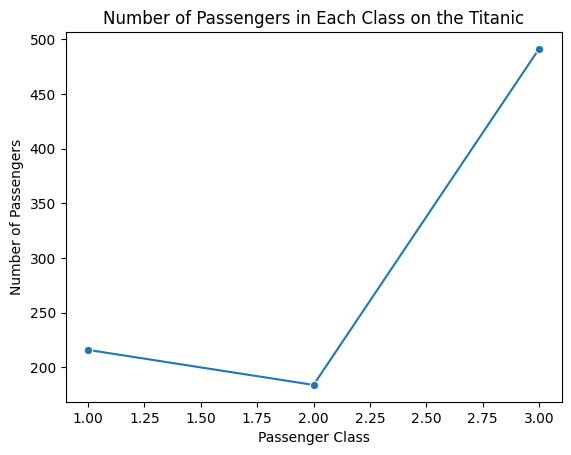

In [18]:
#Line plot for number of passenger in each class

class_count = train['Pclass'].value_counts().sort_index()

sns.lineplot(x=class_count.index, y= class_count.values, marker='o')

plt.title('Number of Passengers in Each Class on the Titanic')
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')

plt.show()

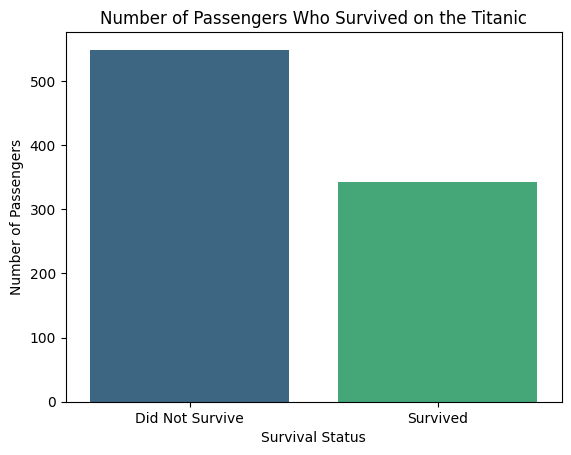

In [19]:
survival_counts = train['Survived'].value_counts().sort_index()
survival_labels = ['Did Not Survive', 'Survived']


sns.barplot(x=survival_labels, y=survival_counts.values, palette='viridis')

# Add title and labels
plt.title('Number of Passengers Who Survived on the Titanic')
plt.xlabel('Survival Status')
plt.ylabel('Number of Passengers')

# Show the plot
plt.show()

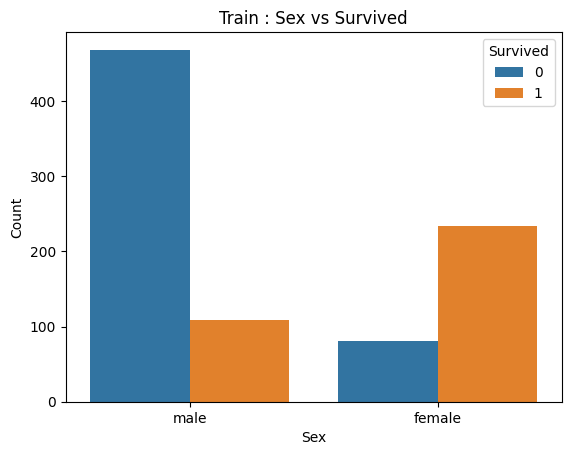

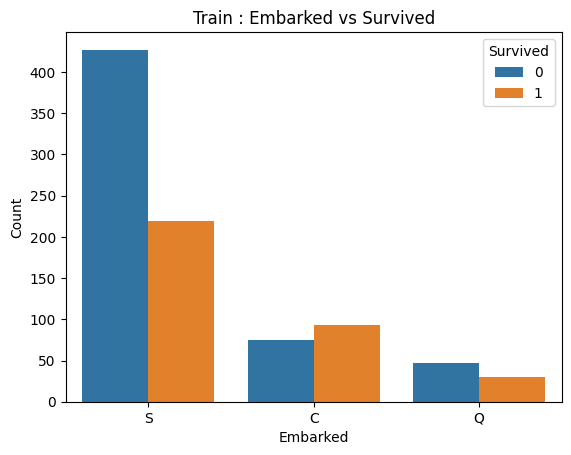

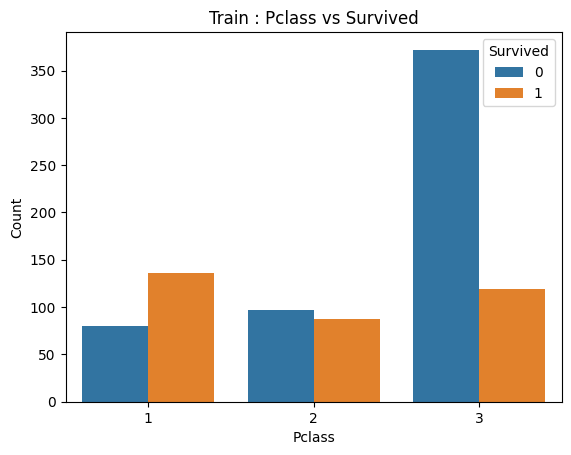

In [20]:
categorical_columns = ['Sex', 'Embarked','Pclass']

for cols in categorical_columns:
    sns.countplot(x=cols, hue='Survived', data=train)
    plt.title(f'Train : {cols} vs Survived')
    plt.xlabel(f'{cols}')
    plt.ylabel('Count')
    plt.show()

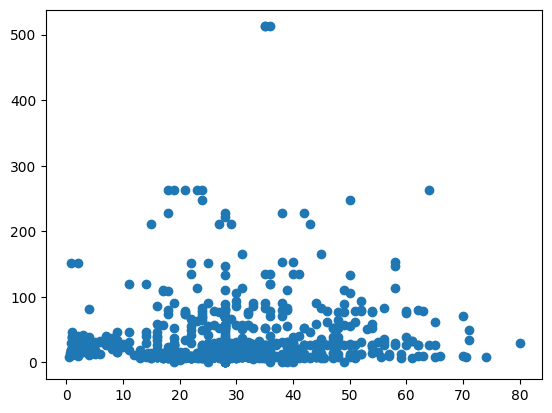

In [21]:
#scatter plot of Age and Fare

plt.scatter(train['Age'], train['Fare'])
plt.show()

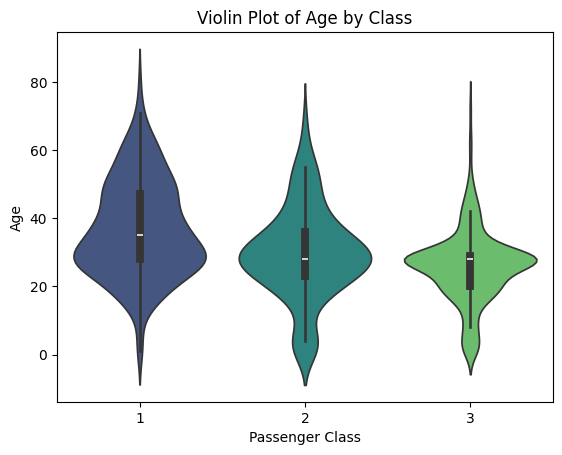

In [22]:
sns.violinplot(x='Pclass', y='Age', data=train, palette='viridis')
plt.title('Violin Plot of Age by Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()


<Axes: xlabel='Age', ylabel='Density'>

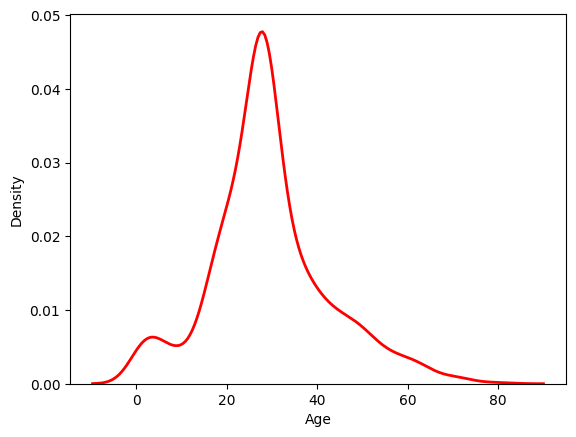

In [23]:
sns.kdeplot(train['Age'], color= 'red', linewidth = 2)

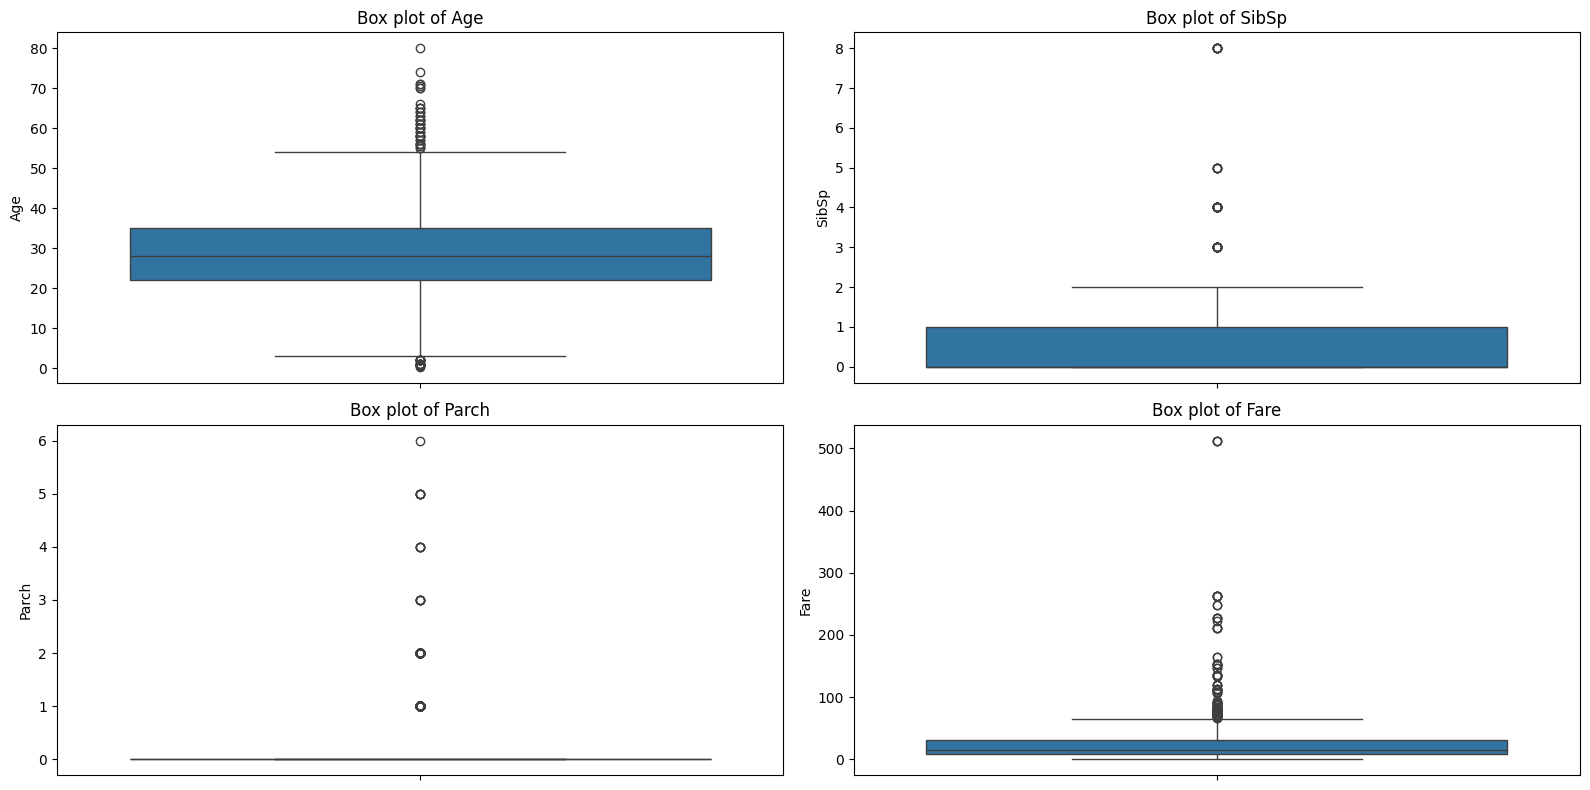

In [24]:
# List of numerical columns
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Plotting box plots for each numerical column
plt.figure(figsize=(16, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=train[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

In [25]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [26]:
# Removing outliers from the 'Fare' column
train_no_outliers = remove_outliers(train, 'Fare')
test_no_outliers = remove_outliers(test, 'Fare')
# Check the shape of the data before and after removing outliers
print(f"Original train shape: {train.shape}")
print(f"Shape after removing outliers: {train_no_outliers.shape}")
print(f"Original test shape: {test.shape}")
print(f"Shape after removing outliers: {test_no_outliers.shape}")

Original train shape: (891, 12)
Shape after removing outliers: (775, 12)
Original test shape: (418, 11)
Shape after removing outliers: (363, 11)


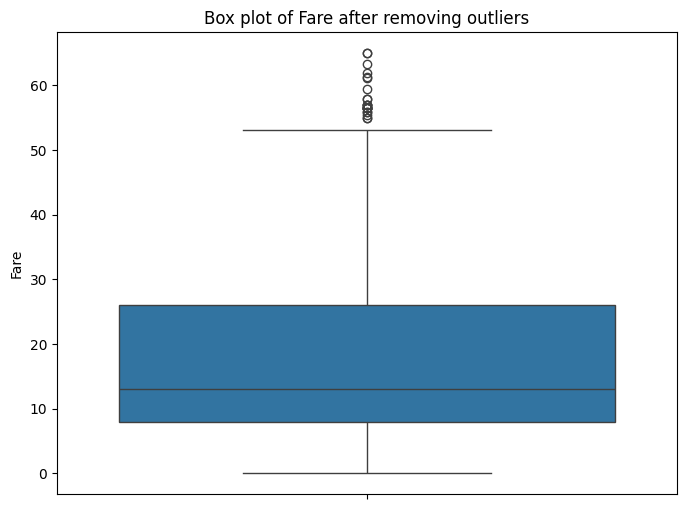

In [27]:
# Box plot after removing outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_no_outliers['Fare'])
plt.title('Box plot of Fare after removing outliers')
plt.show()

In [28]:
def add_title_and_encode(data):
    # Extract titles using a raw string for the regex pattern
    data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major',
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')

    # Apply OneHotEncoder to the 'Title' column
    encoder_title = OneHotEncoder(sparse_output=False, drop='first')
    title_encoded = encoder_title.fit_transform(data[['Title']])

    # Create a DataFrame with the encoded columns and appropriate column names
    title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)

    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, title_encoded_df], axis=1)

    # Drop the original 'Title' column
    data.drop('Title', axis=1, inplace=True)

    # Apply OneHotEncoder to the 'Embarked' column
    encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
    embarked_encoded = encoder_embarked.fit_transform(data[['Embarked']])

    # Create a DataFrame with the encoded columns and appropriate column names
    embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)

    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, embarked_encoded_df], axis=1)

    # Apply OneHotEncoder to the 'Sex' column
    encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
    Sex_encoded = encoder_Sex.fit_transform(data[['Sex']])

    # Create a DataFrame with the encoded columns and appropriate column names
    Sex_encoded_df = pd.DataFrame(Sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)

    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, Sex_encoded_df], axis=1)

    # Apply OneHotEncoder to the 'Pclass' column
    encoder_Pclass = OneHotEncoder(sparse_output=False, drop='first')
    Pclass_encoded = encoder_Pclass.fit_transform(data[['Pclass']])

    # Create a DataFrame with the encoded columns and appropriate column names
    Pclass_encoded_df = pd.DataFrame(Pclass_encoded, columns=encoder_Pclass.get_feature_names_out(['Pclass'])).astype(int)

    # Concatenate the original data with the new one-hot-encoded columns for Pclass
    data = pd.concat([data, Pclass_encoded_df], axis=1)

    # Drop the original 'Sex', 'Pclass', 'Embarked', and other unnecessary columns
    data.drop(['Sex', 'Pclass', 'Embarked', 'Name', 'PassengerId','Cabin','Ticket','Age'], axis=1, inplace=True)

    return data

In [29]:
train = add_title_and_encode(train)
test = add_title_and_encode(test)

In [30]:
test.head()

,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,0,7.8292,0,1,0,0,1,0,1,0,1
1,1,0,7.0000,0,0,1,0,0,1,0,0,1
2,0,0,9.6875,0,1,0,0,1,0,1,1,0
3,0,0,8.6625,0,1,0,0,0,1,1,0,1
4,1,1,12.2875,0,0,1,0,0,1,0,0,1


In [31]:
train.head()

,Survived,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,1,0,7.2500,0,1,0,0,0,1,1,0,1
1,1,1,0,71.2833,0,0,1,0,0,0,0,0,0
2,1,0,0,7.9250,1,0,0,0,0,1,0,0,1
3,1,1,0,53.1000,0,0,1,0,0,1,0,0,0
4,0,0,0,8.0500,0,1,0,0,0,1,1,0,1


In [32]:
# Splitting data into features and target variable
X_train = train.drop('Survived', axis=1)  # Features
y_train = train['Survived']  # Target
print(y_train.shape)
print(X_train.shape)

(891,)
(891, 12)


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [34]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

In [35]:
# Logistic Regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_logreg)

Logistic Regression Accuracy: 0.7988826815642458


In [36]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
accuracy_rfc = accuracy_score(y_val, y_pred_rfc)
print("Random Forest Accuracy:", accuracy_rfc)

Random Forest Accuracy: 0.8268156424581006


In [37]:
# Support Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_val)
accuracy_svc = accuracy_score(y_val, y_pred_svc)
print("Support Vector Machine Accuracy:", accuracy_svc)

Support Vector Machine Accuracy: 0.8156424581005587


In [38]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_val)
print(f'Decision Tree Accuracy: {accuracy_score(y_val, dt_pred):.4f}')

Decision Tree Accuracy: 0.8045


In [39]:
# Gradient Boosting Machine
gbm_model = GradientBoostingClassifier(n_estimators=100)
gbm_model.fit(X_train, y_train)
gbm_pred = gbm_model.predict(X_val)
print(f'Gradient Boosting Accuracy: {accuracy_score(y_val, gbm_pred):.4f}')

Gradient Boosting Accuracy: 0.8268


In [40]:
from xgboost import XGBClassifier

In [41]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
print(f'XGBoost Accuracy: {accuracy_score(y_val, xgb_pred):.4f}')

XGBoost Accuracy: 0.8212


In [42]:
from sklearn.model_selection import KFold, cross_val_score

# Perform k-fold cross-validation
def k_fold_cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return scores

# Applying cross-validation on our training data
cv_scores = k_fold_cross_validation(gbm_model, X_train, y_train, k=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {np.mean(cv_scores):.4f}')

# Predict on test data
predictions = gbm_model.predict(test)

# Evaluate model using output_data (ground truth)
true_values = output_data['Survived']
accuracy = accuracy_score(true_values, predictions)
roc_auc = roc_auc_score(true_values, predictions)

# Print evaluation metrics
print(f"Model accuracy on test data: {accuracy*100:.4f}%")
print(f"Model roc_auc_score on test data: {roc_auc:.4f}")
print(confusion_matrix(output_data['Survived'], predictions))

Cross-validation scores: [0.83916084 0.78321678 0.78873239 0.82394366 0.85915493]
Average cross-validation score: 0.8188
Model accuracy on test data: 90.1914%
Model roc_auc_score on test data: 0.8905
[[248  18]
 [ 23 129]]


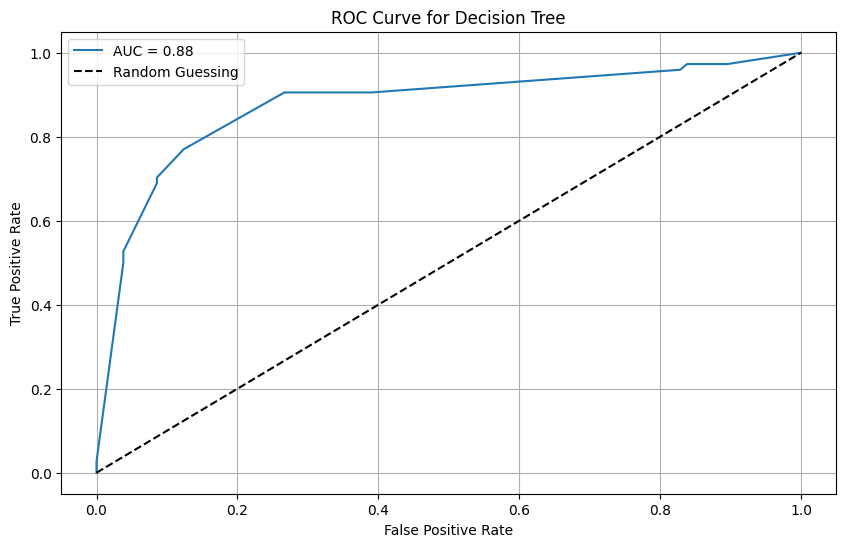

In [43]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_prob = dt.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()